In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 120
hyperparams.BATCH_SIZE = 32

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
MODEL_NAME = "0100_1000-64-convsim-e"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

#from tensorflow.keras.optimizers import RMSprop
#hyperparams.OPTIMIZER = RMSprop(learning_rate=0.0005)
from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)


In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelC as train
import ReportsK as reports
import ConvSimG as model_factory

In [4]:
##################
# MODEL DEFINITION
##################
model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()
model.optimizer.get_config()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 16)   8208        activation_4[0][0]               
______________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [5]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:9696
Nitid files:9696
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2309
Nitid files:2309


In [6]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 20 )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/120
303/303 [==============================] - 11s 16ms/step - loss: 0.0620 - val_loss: 0.0287
Epoch 2/120
303/303 [==============================] - 4s 15ms/step - loss: 0.0290 - val_loss: 0.0252
Epoch 3/120
303/303 [==============================] - 5s 15ms/step - loss: 0.0269 - val_loss: 0.0237
Epoch 4/120
303/303 [==============================] - 4s 14ms/step - loss: 0.0259 - val_loss: 0.0234
Epoch 5/120
303/303 [==============================] - 4s 15ms/step - loss: 0.0253 - val_loss: 0.0227
Epoch 6/120
303/303 [==============================] - 4s 14ms/step - loss: 0.0249 - val_loss: 0.0231
Epoch 7/120
303/303 [==============================] - 4s 14ms/step - loss: 0.0246 - val_loss: 0.0228
Epoch 8/120
303/303 [==============================] - 4s 14ms/step - loss: 0.0243 - val_loss: 0.0223
Epoch 9/120
303/303 [==

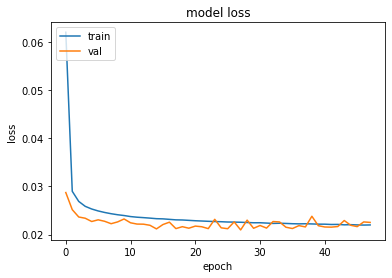

In [7]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [8]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =2309
Best RMSENZ  =2112 (0.91)
Best MAENZ   =2098 (0.91)
Best Accuracy=2022 (0.88)
RMSE-NZ  Pred=0.0290  Noisy=0.0943
MAE-NZ   Pred=0.0247  Noisy=0.0904
PSNR     Pred=18.3 dB Noisy=9.3 dB
Accuracy Pred=0.32    Noisy=0.09
SSM      Pred=0.94    Noisy=0.67
HOG MSE  Pred=0.10    Noisy=0.12


In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-convsim-e\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
